# 实验一：道格拉斯-普克实现曲线抽稀

## 算法的伪代码实现

```
function DouglasPeucker(PointList, epsilon):
    if length(PointList) <= 2:
        return PointList
    
    // 找到离首尾连线最远的点
    dmax = 0
    index = 0
    for i = 1 to length(PointList)-2:
        d = perpendicular_distance(PointList[i], Line(PointList[0], PointList[-1]))
        if d > dmax:
            index = i
            dmax = d
    
    // 递归处理
    if dmax > epsilon:
        result1 = DouglasPeucker(PointList[0:index+1], epsilon)
        result2 = DouglasPeucker(PointList[index:], epsilon)
        return result1[:-1] + result2
    else:
        return [PointList[0], PointList[-1]]
```

In [1]:
import math

def perpendicular_distance(point, line_start, line_end):
    if line_start == line_end:
        return math.sqrt((point[0]-line_start[0])**2 + (point[1]-line_start[1])**2)
    
    x1, y1 = line_start
    x2, y2 = line_end
    x0, y0 = point
    
    numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
    denominator = math.sqrt((y2-y1)**2 + (x2-x1)**2)
    
    return numerator / denominator if denominator != 0 else 0

def douglas_peucker(points, epsilon):
    if len(points) <= 2:
        return points
    
    max_distance = 0
    max_index = 0
    
    for i in range(1, len(points)-1):
        distance = perpendicular_distance(points[i], points[0], points[-1])
        if distance > max_distance:
            max_index = i
            max_distance = distance
            
    if max_distance > epsilon:
        left_result = douglas_peucker(points[:max_index+1], epsilon)
        right_result = douglas_peucker(points[max_index:], epsilon)
        return left_result[:-1] + right_result
    else:
        return [points[0], points[-1]]

def calculate_compression_ratio(original_points, simplified_points):
    return len(original_points) / len(simplified_points)

def calculate_compression_error(original_points, simplified_points):
    total_error = 0
    
    for point in original_points:
        min_distance = float('inf')
        # 找到原始点到简化折线的最短距离
        for i in range(len(simplified_points)-1):
            distance = perpendicular_distance(point, simplified_points[i], simplified_points[i+1])
            min_distance = min(min_distance, distance)
        total_error += min_distance
    
    return total_error / len(original_points)

In [2]:
# 测试曲线
original_curve = [(0.0, 0.0497), (0.526, 0.4885), (1.053, 0.9335), (1.579, 1.1523), (2.105, 0.8371), (2.632, 0.4648), (3.158, 0.6416), (3.684, -0.4396), (4.211, -0.9236), (4.737, -0.8454), (5.263, -0.8985), (5.789, -0.5205), (6.316, 0.0568), (6.842, 0.7689), (7.368, 0.7119), (7.895, 0.9429), (8.421, 0.7422), (8.947, 0.4909), (9.474, -0.1397), (10.0, -0.6853)]
print(f"原始曲线节点数: {len(original_curve)}")

thresholds = [0.1, 0.3, 0.5]

for i, threshold in enumerate(thresholds):
    print(f"\n=== 测试 {i+1}: 阈值 = {threshold} ===")
    
    simplified_curve = douglas_peucker(original_curve, threshold)
    
    compression_ratio = calculate_compression_ratio(original_curve, simplified_curve)
    compression_error = calculate_compression_error(original_curve, simplified_curve)
    
    print(f"抽稀后节点数: {len(simplified_curve)}")
    print(f"压缩率: {compression_ratio:.2f}")
    print(f"压缩误差: {compression_error:.4f}")
    
    print("抽稀后的前5个坐标点:")
    for j, point in enumerate(simplified_curve[:5]):
        print(f"  ({point[0]:.3f}, {point[1]:.3f})")

原始曲线节点数: 20

=== 测试 1: 阈值 = 0.1 ===
抽稀后节点数: 14
压缩率: 1.43
压缩误差: 0.0087
抽稀后的前5个坐标点:
  (0.000, 0.050)
  (1.053, 0.933)
  (1.579, 1.152)
  (2.632, 0.465)
  (3.158, 0.642)

=== 测试 2: 阈值 = 0.3 ===
抽稀后节点数: 9
压缩率: 2.22
压缩误差: 0.0678
抽稀后的前5个坐标点:
  (0.000, 0.050)
  (1.579, 1.152)
  (2.632, 0.465)
  (3.158, 0.642)
  (4.211, -0.924)

=== 测试 3: 阈值 = 0.5 ===
抽稀后节点数: 7
压缩率: 2.86
压缩误差: 0.1101
抽稀后的前5个坐标点:
  (0.000, 0.050)
  (1.579, 1.152)
  (3.158, 0.642)
  (4.211, -0.924)
  (5.263, -0.898)


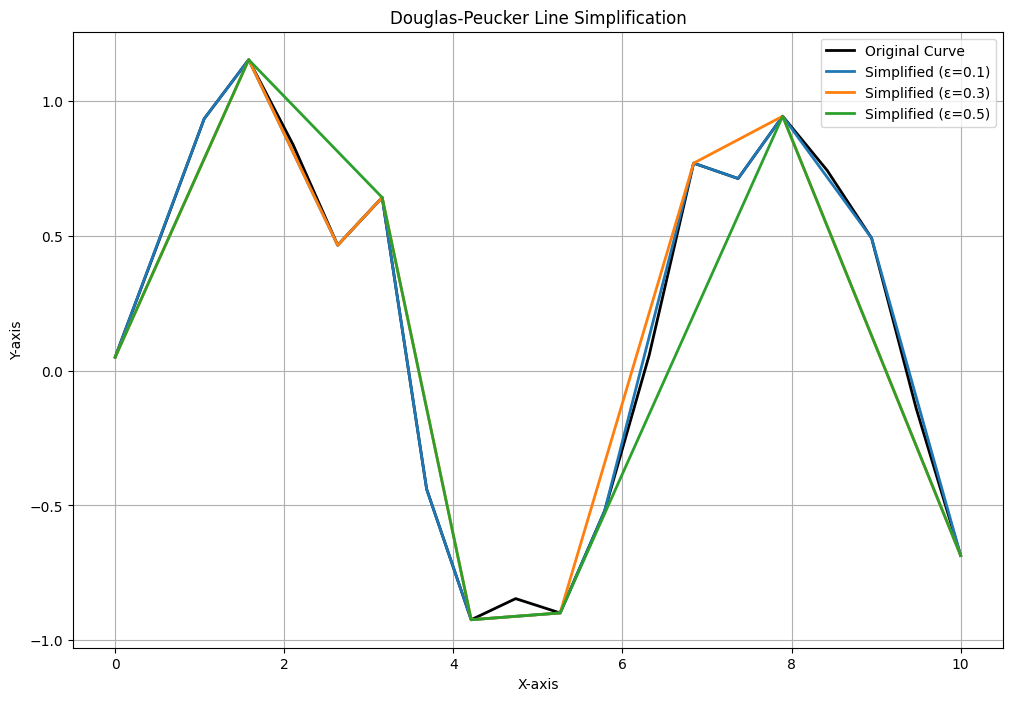

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.plot(*zip(*original_curve), label='Original Curve', color='black', linewidth=2)
for threshold in thresholds:
    simplified_curve = douglas_peucker(original_curve, threshold)
    plt.plot(*zip(*simplified_curve), label=f'Simplified (ε={threshold})', linewidth=2)
plt.legend()
plt.title('Douglas-Peucker Line Simplification')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid()
plt.show()

## 简答题：自动计算阈值的模型

1. 基于曲线特征的自适应阈值模型
   ```python
   def adaptive_threshold(points):
       # 计算曲线的总长度
       total_length = 0
       for i in range(len(points)-1):
           dx = points[i+1][0] - points[i][0]
           dy = points[i+1][1] - points[i][1]
           total_length += math.sqrt(dx*dx + dy*dy)
       
       # 基于曲线长度和点密度的自适应阈值
       point_density = len(points) / total_length
       return total_length * 0.02 / point_density  # 可调节系数
   ```

2. 基于曲率变化的阈值模型
   - 计算各点的曲率变化率
   - 在曲率变化大的区域使用较小阈值，平坦区域使用较大阈值

3. 目标压缩率驱动模型
   ```python
   def find_threshold_by_ratio(points, target_ratio):
       low, high = 0, max_distance(points)
       while high - low > 1e-6:
           mid = (low + high) / 2
           simplified = douglas_peucker(points, mid)
           current_ratio = len(points) / len(simplified)
           if current_ratio > target_ratio:
               low = mid
           else:
               high = mid
       return (low + high) / 2
   ```

4. 统计分析模型
   - 计算所有点到弦距离的统计特征（均值、方差等）
   - 根据统计特征动态设定阈值：`threshold = mean + k * std`

5. 机器学习模型
   - 使用历史数据训练回归模型
   - 输入：曲线特征（长度、点数、曲率方差等）
   - 输出：最优阈值